# May 2018 Alternative Evaluation for YAP 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os 
from glob import glob

sns.set_context('talk')
sns.set_style("white")
sns.set_palette('Set2', 10)
%matplotlib inline

In [43]:
dev_dir = r'MAY18\yap_dev'
test_dir = r'MAY18\yap_test'

dev_paths = glob(os.path.join(dev_dir, '*inf.conll'))
dev_gold_path = os.path.join(dev_dir, 'dev.hebtb.lgold.conll')
test_paths = glob(os.path.join(test_dir, '*inf.conll'))
test_gold_path = os.path.join(test_dir, 'test.hebtb.lgold.conll')

In [15]:
def make_conll_df(path):
    # CoNLL file is tab delimeted with no quoting
    # quoting=3 is csv.QUOTE_NONE
    df = (pd.read_csv(path, sep='\t', header=None, quoting=3, 
                names = ['ID', 'FORM', 'LEMMA', 'UPOS', 'XPOS', 'FEATS', 'HEAD', 'DEPREL', 'DEPS', 'MISC'])
                # add sentence labels
                .assign(sent = lambda x: (x.ID==1).cumsum())
                # replace bad root dependency tags
                .replace({'DEPREL': {'prd': 'ROOT'}})
               )
    
    df = df.merge(df[['ID', 'FORM', 'sent', 'UPOS']].rename(index=str, columns={'FORM': 'head_form', 'UPOS': 'head_upos'}).set_index(['sent', 'ID']),
               left_on=['sent', 'HEAD'], right_index=True, how='left')
    return df

In [44]:
dev_gold = make_conll_df(dev_gold_path)
dev_dfs  = list(map(make_conll_df, dev_paths))
test_gold = make_conll_df(test_gold_path)
test_dfs = list(map(make_conll_df, test_paths))

## Evaluate

Handwavy pseudo-algorithm
```
1. points = 0
1. For each sentence
    1. g <- set(gold[FORM, UPOS, DEPREL, head_form])
    1. t <- set(test[FORM, UPOS, DEPREL, head_form])
    1. points += len(g.intersection(t)) / avg(len(gold, test))```
   
Or in words - for each test sentence, get the number of correct tags using set intersection with the gold sentence, and then normalize by the sentence length.

The current normalization uses the avg length of the sentences between g and t

In [26]:
EVAL_COLS = ['FORM', 'UPOS', 'DEPREL', 'head_form']

def score(t, g = gold, columns = EVAL_COLS):
    # get sentence number in scalar form
    sent = t.iloc[0,10]
    # get the correct gold sentence
    g = g[g.sent==sent]
    
    # value for normalization
    norm = (t.shape[0] + g.shape[0]) / 2
    
    #use pandas index set logic to get the intersection
    g = g.set_index(columns)
    t = t.set_index(columns)
    
    return len(g.index.intersection(t.index)) / norm

In [45]:
dev_scores = [df.groupby('sent').apply(score, g=dev_gold) for df in dev_dfs]

In [46]:
test_scores = [df.groupby('sent').apply(score, g=test_gold) for df in test_dfs]

#### Remove punctuation chars and re-evaluate

In [29]:
def depunct(df):
    new_df = df.fillna({'head_upos': '___', 'head_form': '___'}).copy()
    new_df = new_df[~new_df.UPOS.str.startswith('yy')]
    new_df.loc[new_df['head_upos'].str.startswith('yy', na=False), 'head_form'] = '___'
    return new_df

In [104]:
dev_nop = list(map(depunct, dev_dfs))
dev_gold_nop = depunct(dev_gold)
test_nop = list(map(depunct, test_dfs))
test_gold_nop = depunct(test_gold)

dev_nop_scores = [df.groupby('sent').apply(score, g=dev_gold_nop) for df in dev_nop]
test_nop_scores = [df.groupby('sent').apply(score, g=test_gold_nop) for df in test_nop]

### Mean Scores
#### With punctuation

In [47]:
{path: s.mean() for path, s in zip(dev_paths, dev_scores)}

{'MAY18\\yap_dev\\joint_arc_standard_i28_dev_hebtb_inf.conll': 0.678709754454883,
 'MAY18\\yap_dev\\joint_arc_standard_i28_dev_hebtb_uninf.conll': 0.6600710643131267,
 'MAY18\\yap_dev\\joint_arc_zeager_i33_dev_hebtb_inf.conll': 0.7137305982920923,
 'MAY18\\yap_dev\\joint_arc_zeager_i33_dev_hebtb_uninf.conll': 0.6966799310081466,
 'MAY18\\yap_dev\\joint_md_standard_i18_dev_hebtb_inf.conll': 0.6756745760202062,
 'MAY18\\yap_dev\\joint_md_standard_i18_dev_hebtb_uninf.conll': 0.6530882258291358,
 'MAY18\\yap_dev\\joint_md_zeager_i16_dev_hebtb_inf.conll': 0.7140945441623806,
 'MAY18\\yap_dev\\joint_md_zeager_i16_dev_hebtb_uninf.conll': 0.6931340696677343,
 'MAY18\\yap_dev\\pipeline_standard_i15_dev_hebtb_inf.conll': 0.6751984410988795,
 'MAY18\\yap_dev\\pipeline_standard_i15_dev_hebtb_uninf.conll': 0.6442576816146195,
 'MAY18\\yap_dev\\pipeline_zeager_i18_dev_hebtb_inf.conll': 0.7190333369902111,
 'MAY18\\yap_dev\\pipeline_zeager_i18_dev_hebtb_uninf.conll': 0.6838341089489667}

In [48]:
{path: s.mean() for path, s in zip(test_paths, test_scores)}

{'MAY18\\yap_test\\joint_arc_standard_i28_test_hebtb_inf.conll': 0.6590152873731572,
 'MAY18\\yap_test\\joint_arc_standard_i28_test_hebtb_uninf.conll': 0.632745548369643,
 'MAY18\\yap_test\\joint_arc_zeager_i33_test_hebtb_inf.conll': 0.6896187239790226,
 'MAY18\\yap_test\\joint_arc_zeager_i33_test_hebtb_uninf.conll': 0.6553351175046328,
 'MAY18\\yap_test\\joint_md_standard_i18_test_hebtb_inf.conll': 0.6560728659075798,
 'MAY18\\yap_test\\joint_md_standard_i18_test_hebtb_uninf.conll': 0.6320542612594967,
 'MAY18\\yap_test\\joint_md_zeager_i16_test_hebtb_inf.conll': 0.6860586075829295,
 'MAY18\\yap_test\\joint_md_zeager_i16_test_hebtb_uninf.conll': 0.6575091580842668,
 'MAY18\\yap_test\\pipeline_standard_i15_test_hebtb_inf.conll': 0.6789117559915088,
 'MAY18\\yap_test\\pipeline_standard_i15_test_hebtb_uninf.conll': 0.6123440237965398,
 'MAY18\\yap_test\\pipeline_zeager_i18_test_hebtb_inf.conll': 0.7086595274150629,
 'MAY18\\yap_test\\pipeline_zeager_i18_test_hebtb_uninf.conll': 0.6441449

#### Without Punctuation

In [51]:
{path: s.mean() for path, s in zip(dev_paths, dev_nop_scores)}

{'MAY18\\yap_dev\\joint_arc_standard_i28_dev_hebtb_inf.conll': 0.6700622630745344,
 'MAY18\\yap_dev\\joint_arc_standard_i28_dev_hebtb_uninf.conll': 0.6506186317846993,
 'MAY18\\yap_dev\\joint_arc_zeager_i33_dev_hebtb_inf.conll': 0.7115370678249575,
 'MAY18\\yap_dev\\joint_arc_zeager_i33_dev_hebtb_uninf.conll': 0.6926481354954972,
 'MAY18\\yap_dev\\joint_md_standard_i18_dev_hebtb_inf.conll': 0.6678414466025371,
 'MAY18\\yap_dev\\joint_md_standard_i18_dev_hebtb_uninf.conll': 0.6436273015361169,
 'MAY18\\yap_dev\\joint_md_zeager_i16_dev_hebtb_inf.conll': 0.7107741981360421,
 'MAY18\\yap_dev\\joint_md_zeager_i16_dev_hebtb_uninf.conll': 0.6877655251969766,
 'MAY18\\yap_dev\\pipeline_standard_i15_dev_hebtb_inf.conll': 0.6626587056324826,
 'MAY18\\yap_dev\\pipeline_standard_i15_dev_hebtb_uninf.conll': 0.6291023927096604,
 'MAY18\\yap_dev\\pipeline_zeager_i18_dev_hebtb_inf.conll': 0.7127842529142059,
 'MAY18\\yap_dev\\pipeline_zeager_i18_dev_hebtb_uninf.conll': 0.6762763684947626}

In [52]:
{path: s.mean() for path, s in zip(dev_paths, test_nop_scores)}

{'MAY18\\yap_dev\\joint_arc_standard_i28_dev_hebtb_inf.conll': 0.6516556531816435,
 'MAY18\\yap_dev\\joint_arc_standard_i28_dev_hebtb_uninf.conll': 0.6228274370152523,
 'MAY18\\yap_dev\\joint_arc_zeager_i33_dev_hebtb_inf.conll': 0.685647428537993,
 'MAY18\\yap_dev\\joint_arc_zeager_i33_dev_hebtb_uninf.conll': 0.650399505692213,
 'MAY18\\yap_dev\\joint_md_standard_i18_dev_hebtb_inf.conll': 0.6494441228515692,
 'MAY18\\yap_dev\\joint_md_standard_i18_dev_hebtb_uninf.conll': 0.6219686826809301,
 'MAY18\\yap_dev\\joint_md_zeager_i16_dev_hebtb_inf.conll': 0.6839510921372626,
 'MAY18\\yap_dev\\joint_md_zeager_i16_dev_hebtb_uninf.conll': 0.6519652426067928,
 'MAY18\\yap_dev\\pipeline_standard_i15_dev_hebtb_inf.conll': 0.6705405165292654,
 'MAY18\\yap_dev\\pipeline_standard_i15_dev_hebtb_uninf.conll': 0.6009255324194337,
 'MAY18\\yap_dev\\pipeline_zeager_i18_dev_hebtb_inf.conll': 0.7043212638557763,
 'MAY18\\yap_dev\\pipeline_zeager_i18_dev_hebtb_uninf.conll': 0.6361230274875299}

### Length vs. Score

#### With Punctuation - DEV
##### Scatter plot with regression line

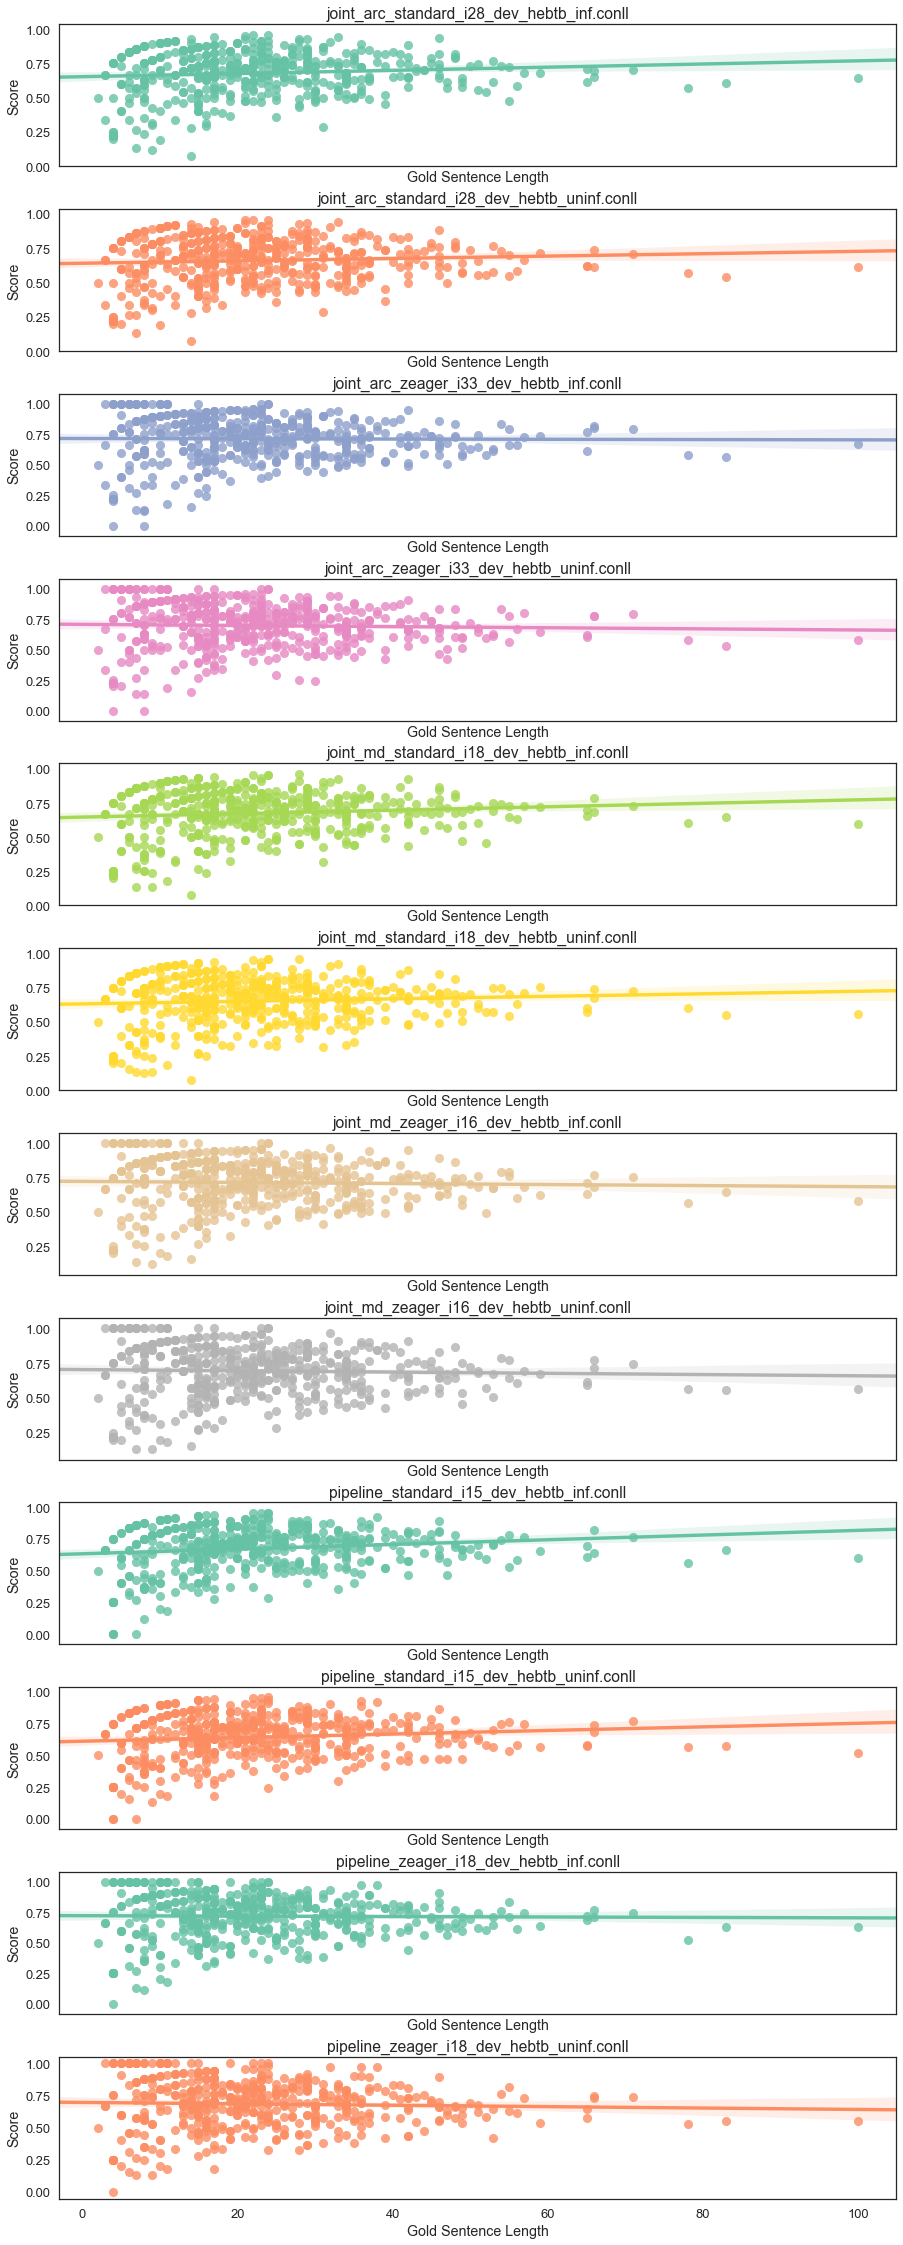

In [92]:
dev_gold_len = dev_gold.groupby('sent').size()

f, axes = plt.subplots(len(dev_paths), 1, figsize=(15,40), sharex=True)
for i, ax in enumerate(f.axes):
    sns.regplot(x=dev_gold_len, y=dev_scores[i], ax=ax)
    ax.set_xlabel('Gold Sentence Length')
    ax.set_ylabel('Score')
    ax.set_title(os.path.basename(dev_paths[i]))
f.subplots_adjust(hspace=0.3)

#### Bivariate KDE Plot

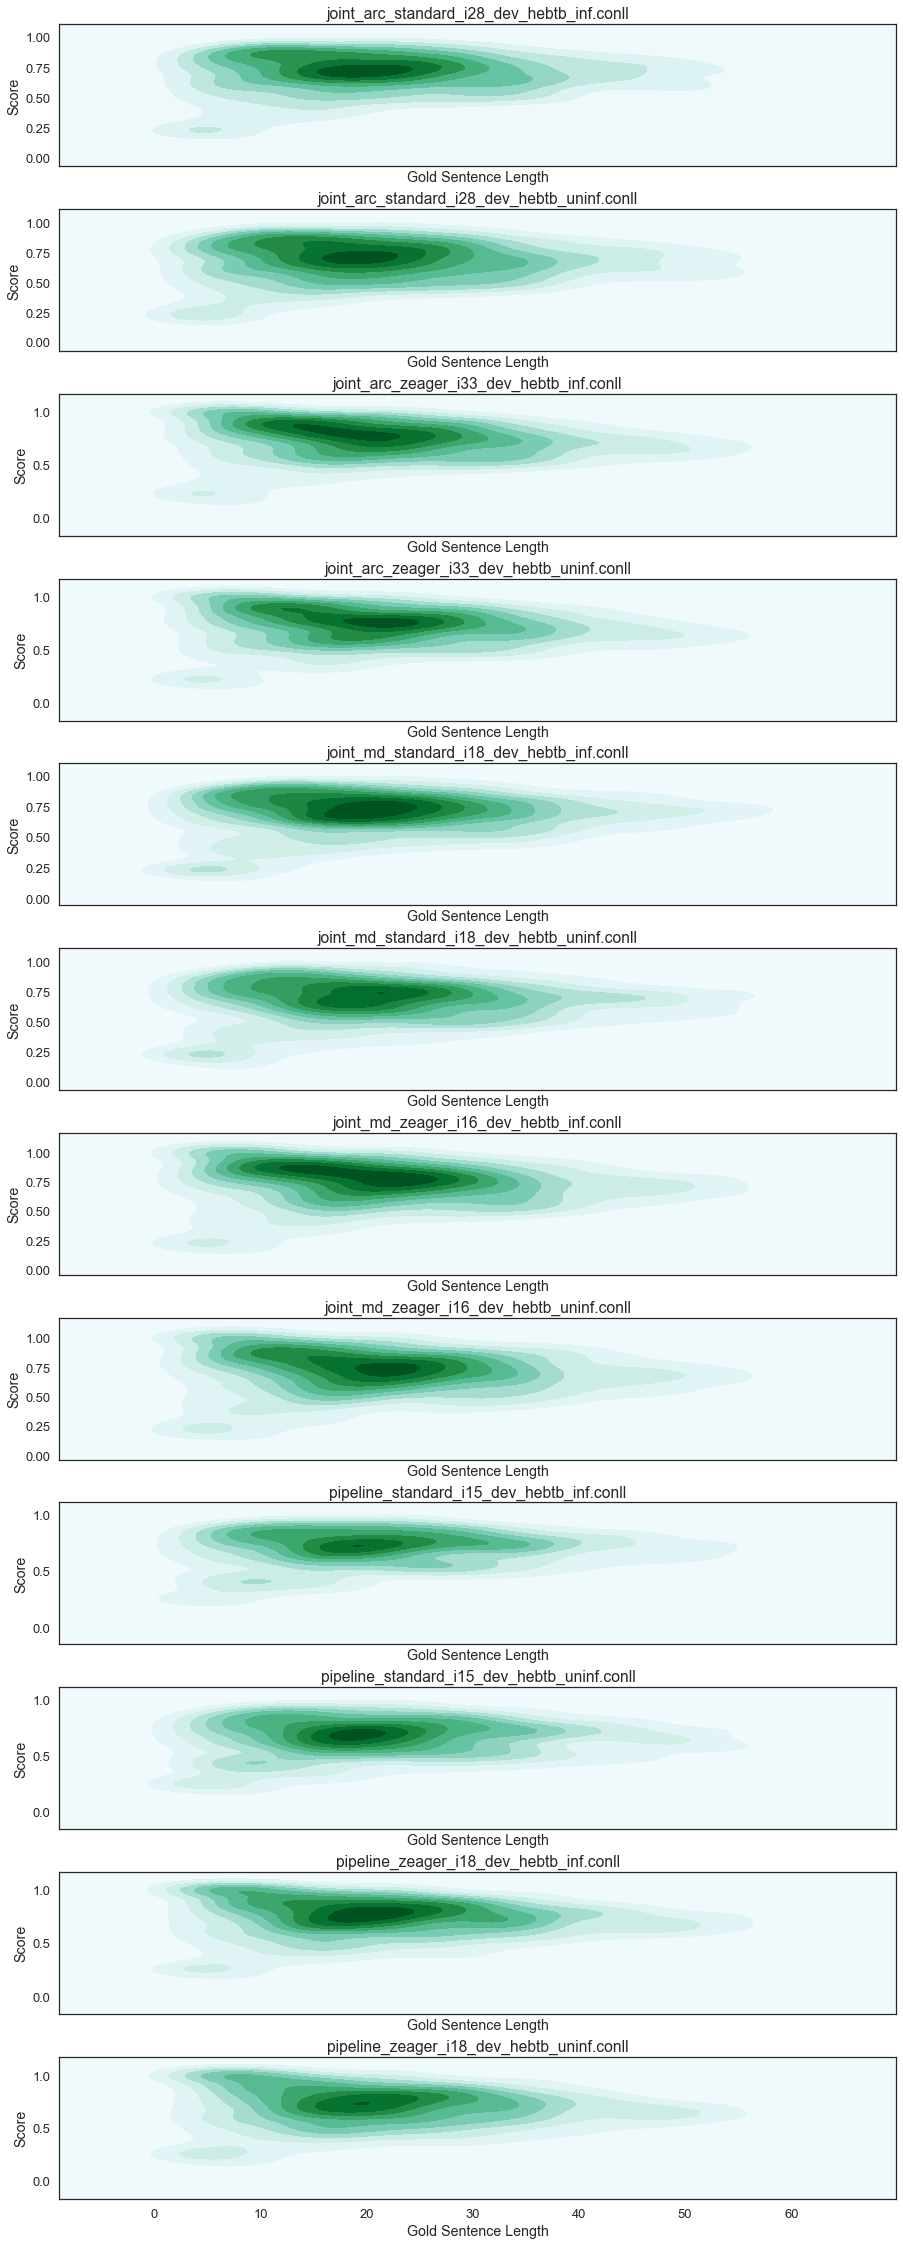

In [86]:
f, axes = plt.subplots(len(dev_paths), 1, figsize=(15,40), sharex=True)
for i, ax in enumerate(f.axes):
    sns.kdeplot(dev_gold_len[dev_gold_len<60], dev_scores[i][dev_gold_len<60], shade=True, ax=ax)
    ax.set_xlabel('Gold Sentence Length')
    ax.set_ylabel('Score')
    ax.set_title(os.path.basename(dev_paths[i]))
f.subplots_adjust(hspace=0.3)

#### With Punctuation - TEST
##### Scatter plot with regression line

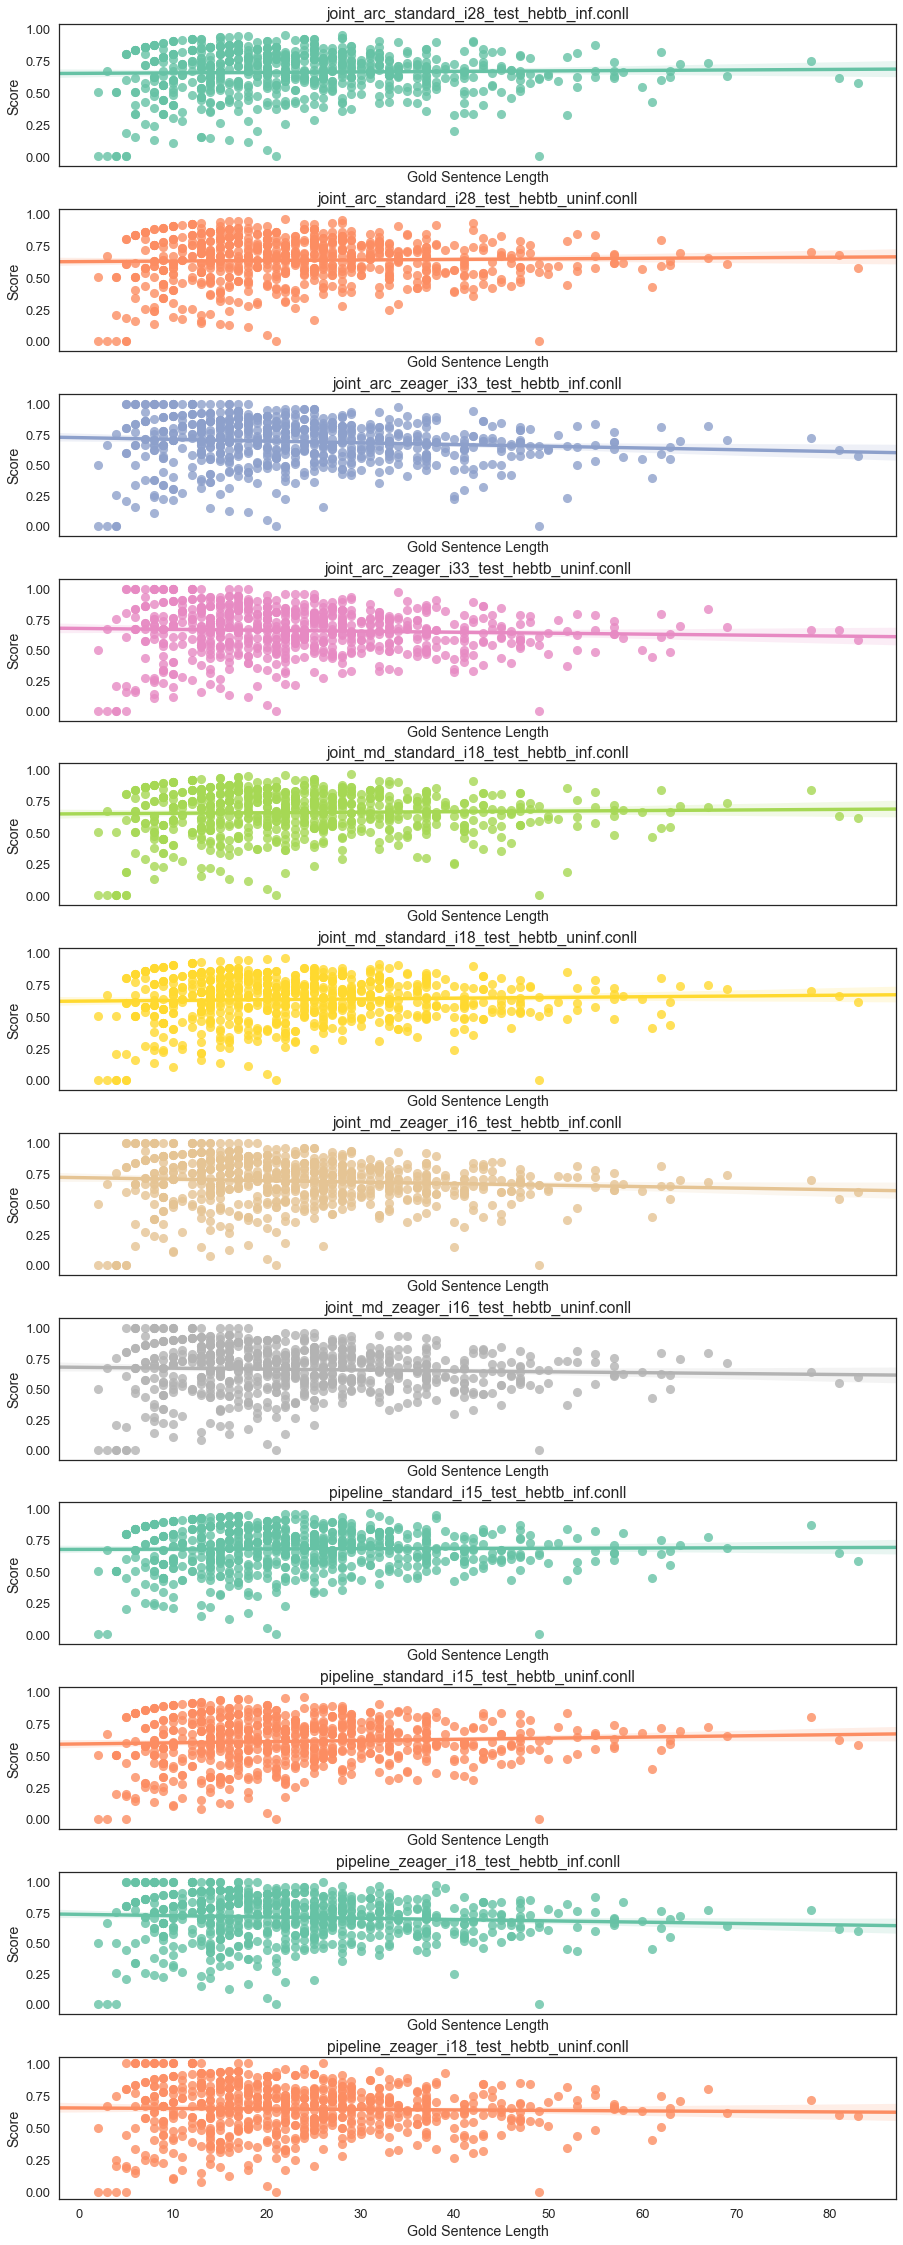

In [93]:
test_gold_len = test_gold.groupby('sent').size()

f, axes = plt.subplots(len(test_paths), 1, figsize=(15,40), sharex=True)
for i, ax in enumerate(f.axes):
    sns.regplot(x=test_gold_len, y=test_scores[i], ax=ax)
    ax.set_xlabel('Gold Sentence Length')
    ax.set_ylabel('Score')
    ax.set_title(os.path.basename(test_paths[i]))
f.subplots_adjust(hspace=0.3)

##### Bivariate KDE plot

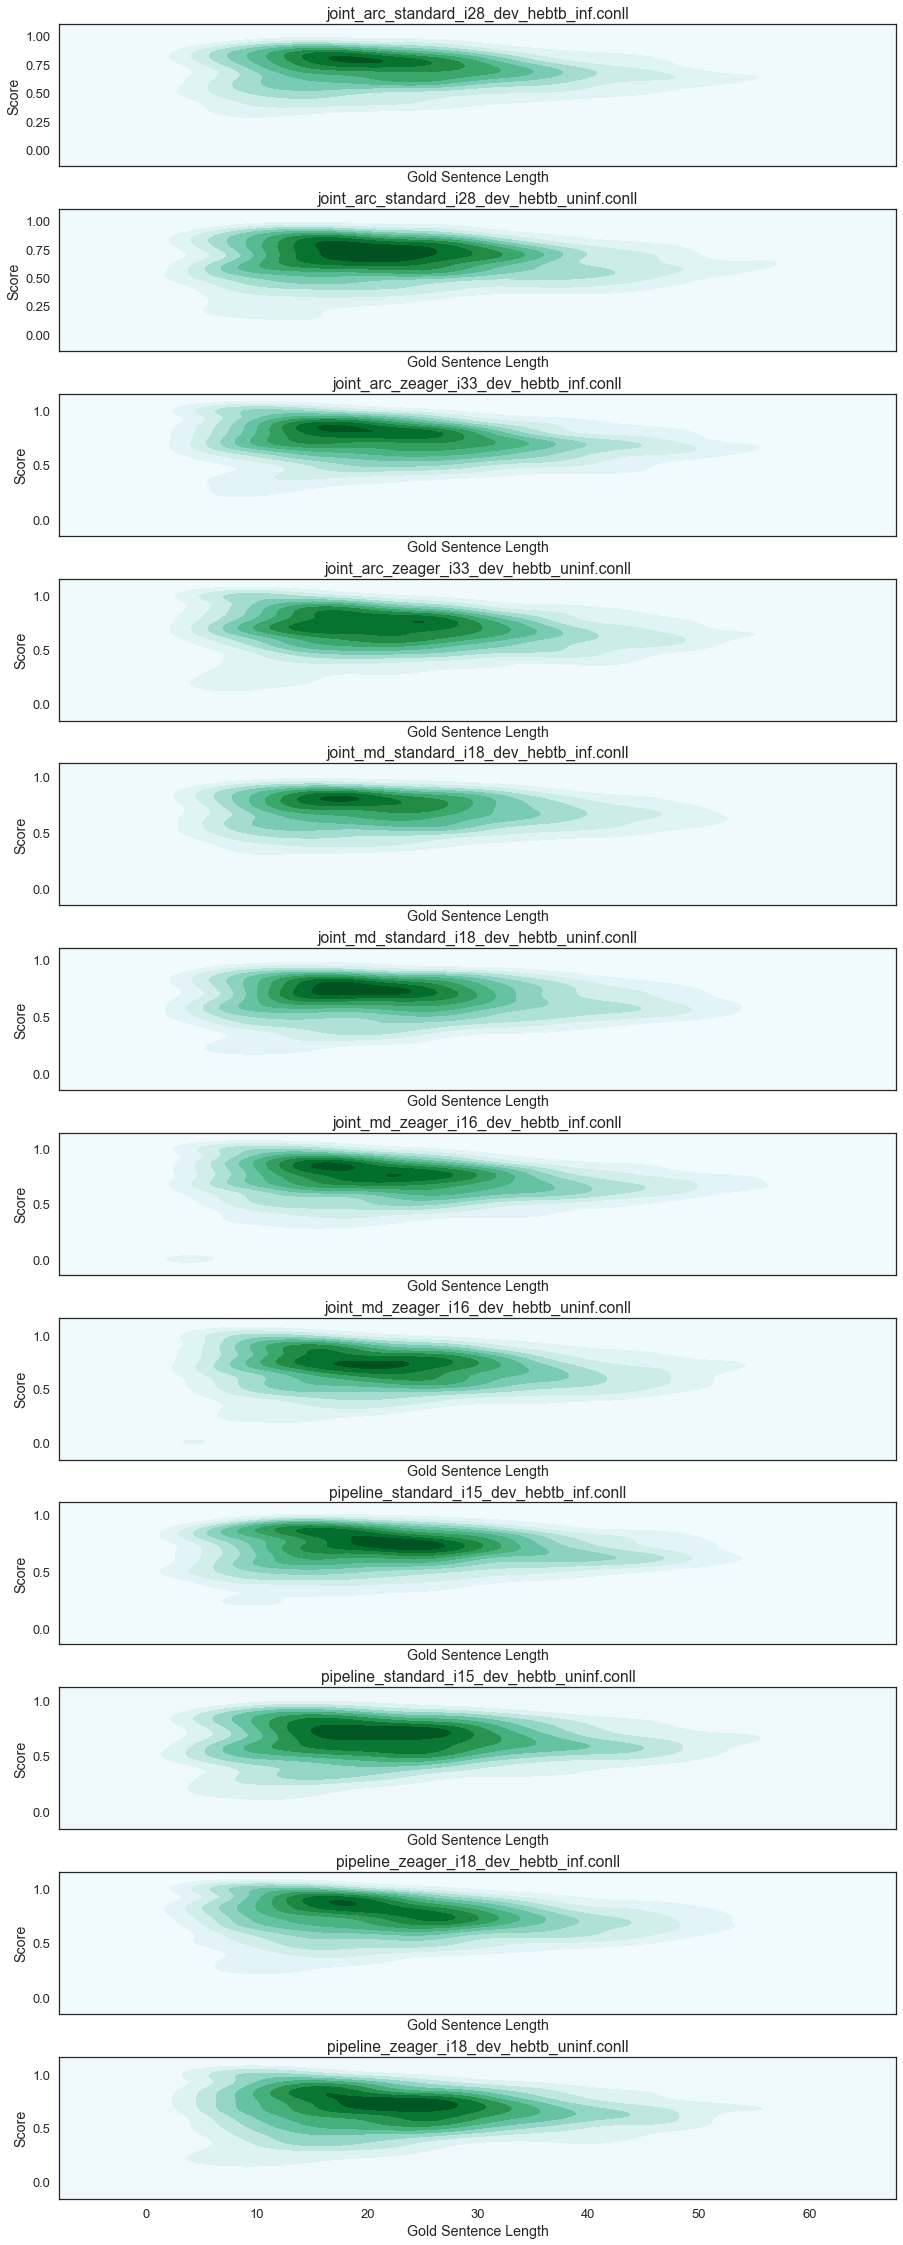

In [94]:
f, axes = plt.subplots(len(test_paths), 1, figsize=(15,40), sharex=True)
for i, ax in enumerate(f.axes):
    sns.kdeplot(test_gold_len[test_gold_len<60], test_scores[i][test_gold_len<60], shade=True, ax=ax)
    ax.set_xlabel('Gold Sentence Length')
    ax.set_ylabel('Score')
    ax.set_title(os.path.basename(dev_paths[i]))
f.subplots_adjust(hspace=0.3)

#### Without Punctuation - DEV

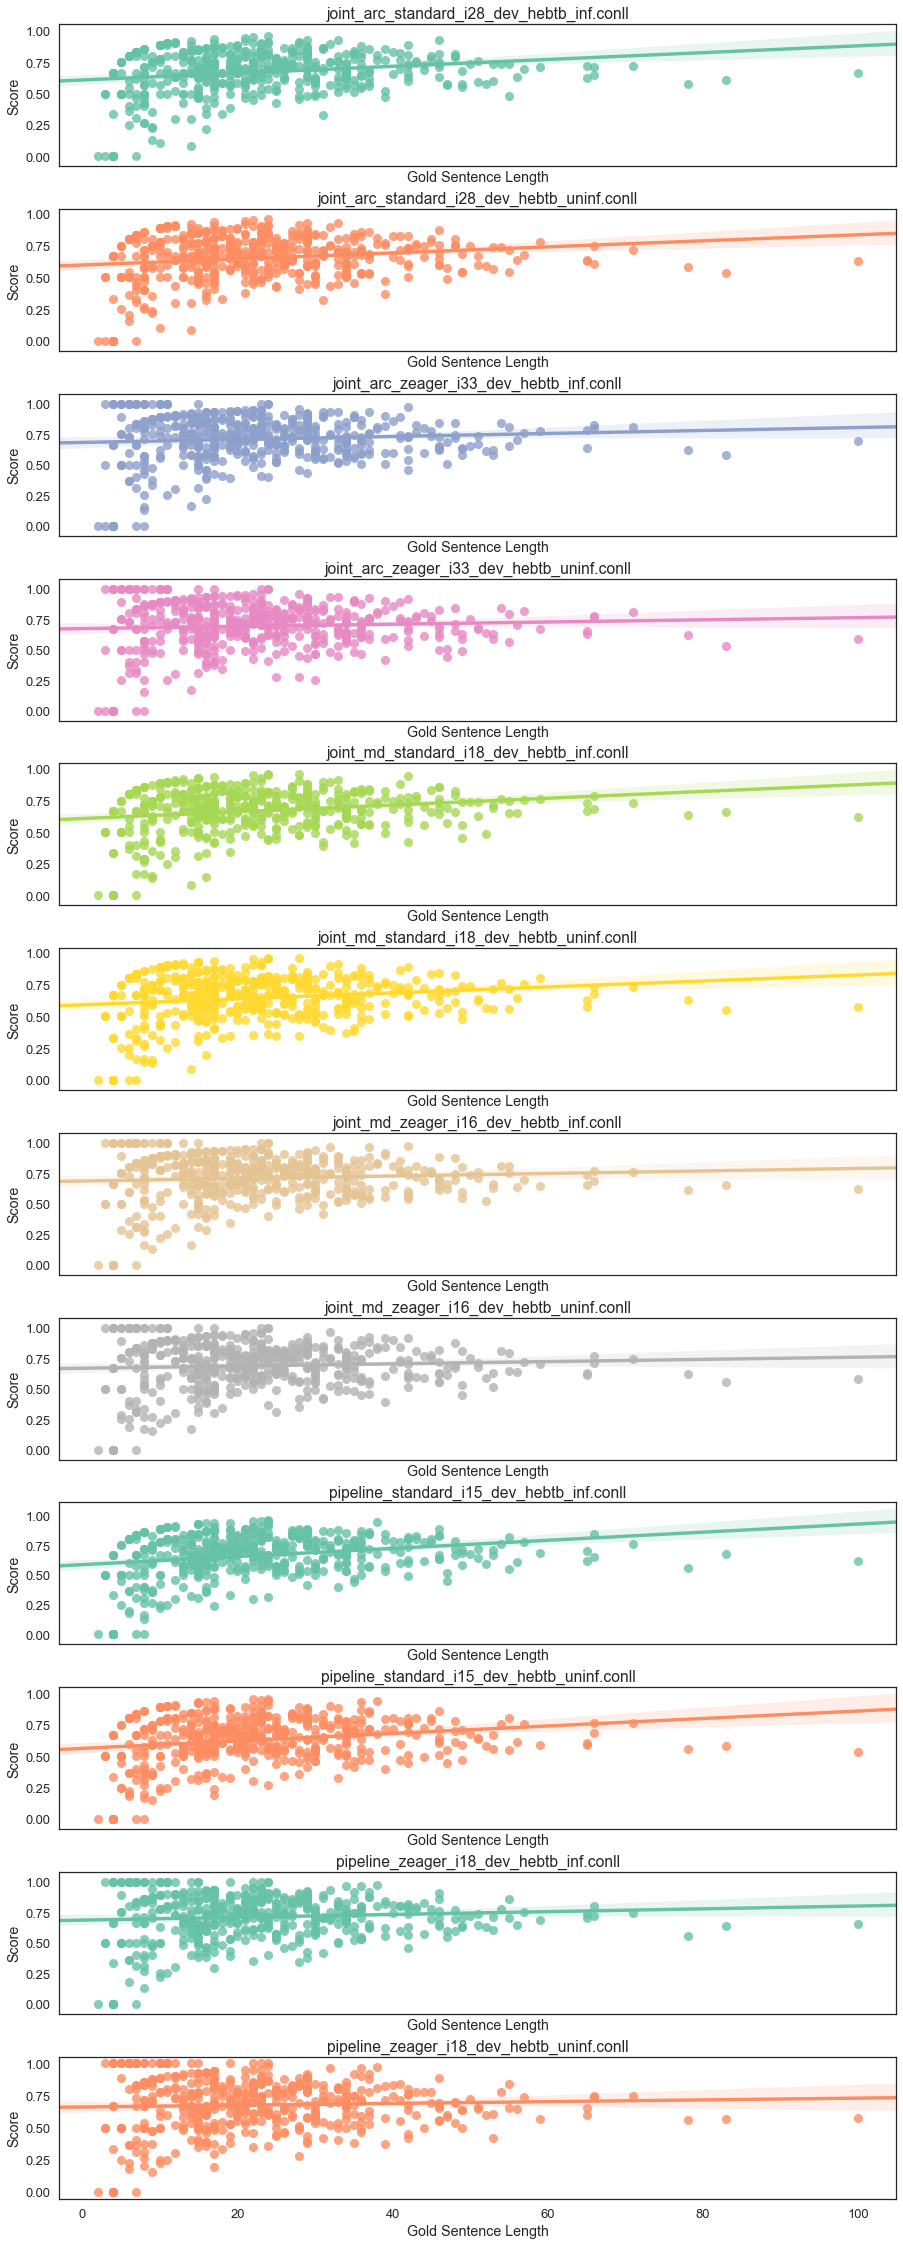

In [95]:
f, axes = plt.subplots(len(dev_paths), 1, figsize=(15,40), sharex=True)
for i, ax in enumerate(f.axes):
    sns.regplot(x=dev_gold_len, y=dev_nop_scores[i], ax=ax)
    ax.set_xlabel('Gold Sentence Length')
    ax.set_ylabel('Score')
    ax.set_title(os.path.basename(dev_paths[i]))
f.subplots_adjust(hspace=0.3)

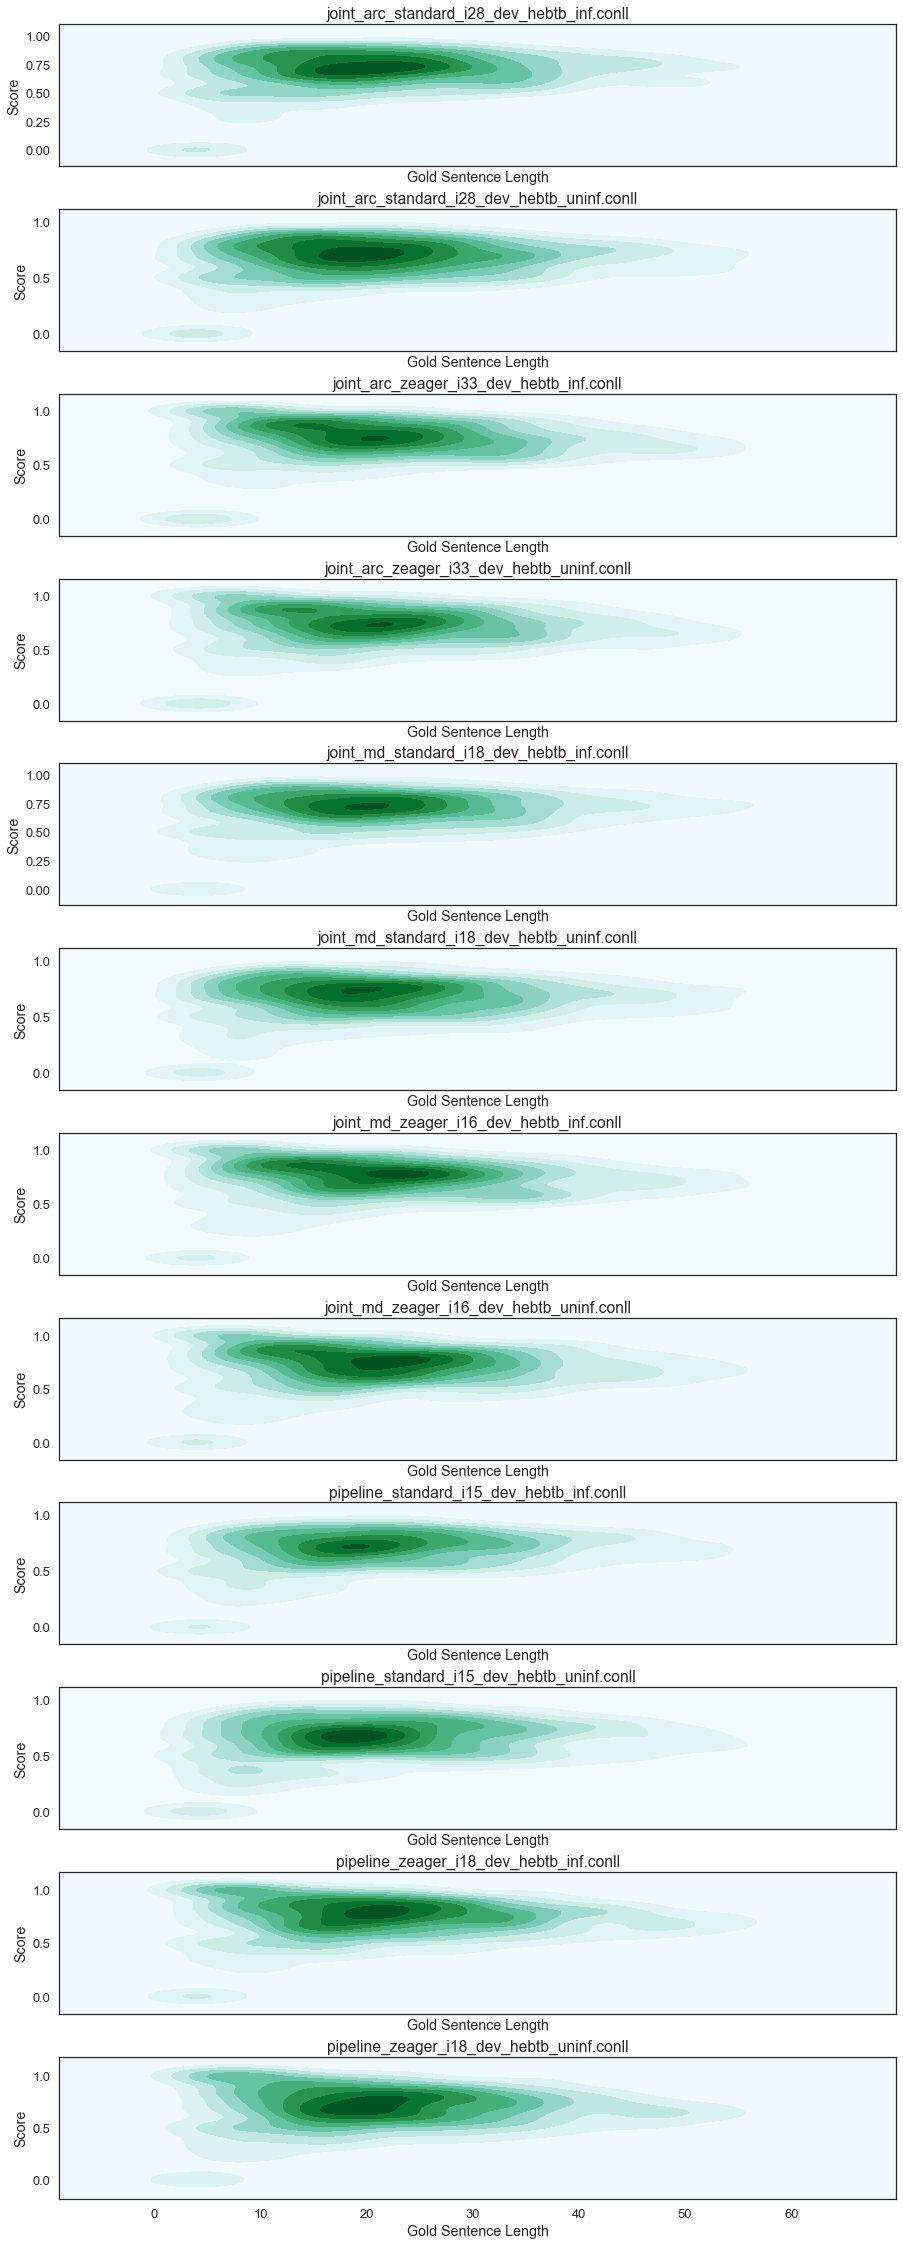

In [96]:
f, axes = plt.subplots(len(dev_paths), 1, figsize=(15,40), sharex=True)
for i, ax in enumerate(f.axes):
    sns.kdeplot(dev_gold_len[dev_gold_len<60], dev_nop_scores[i][dev_gold_len<60], shade=True, ax=ax)
    ax.set_xlabel('Gold Sentence Length')
    ax.set_ylabel('Score')
    ax.set_title(os.path.basename(dev_paths[i]))
f.subplots_adjust(hspace=0.3)

#### Without Punctuation - TEST

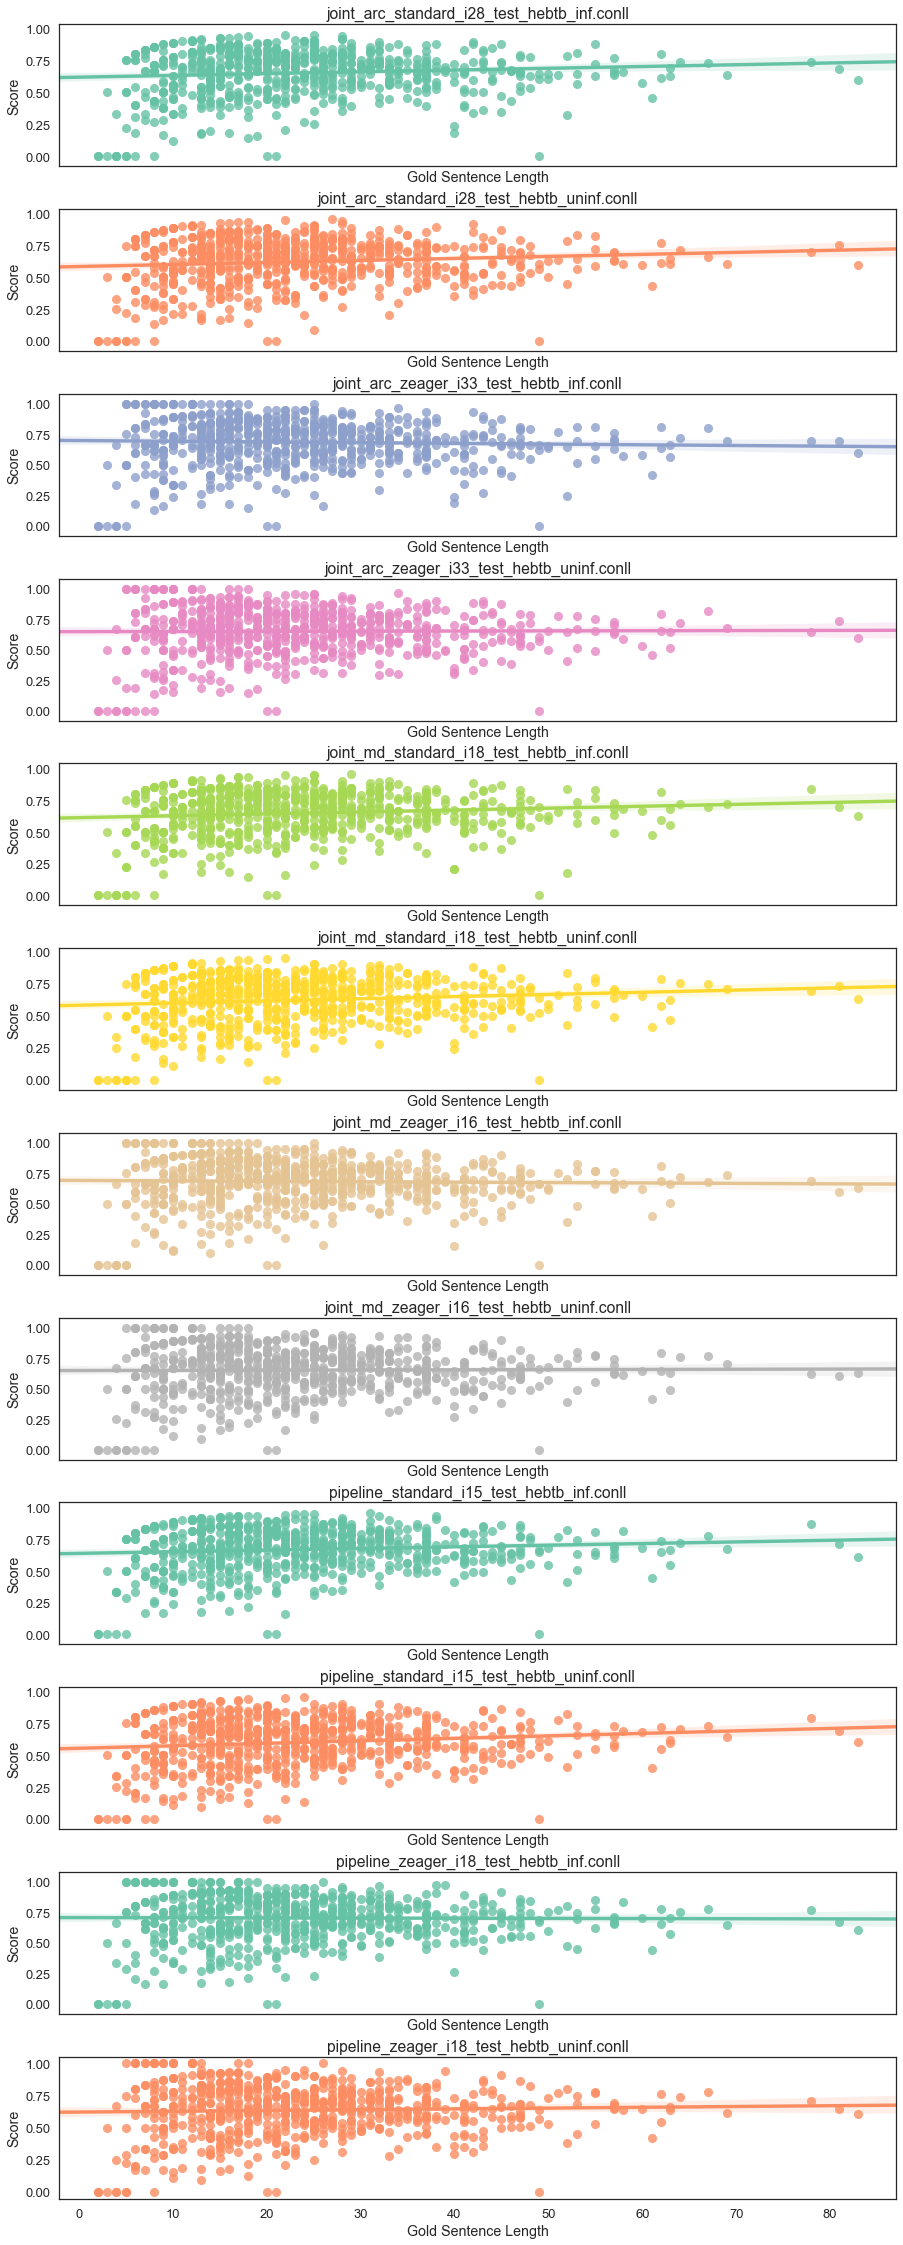

In [97]:
f, axes = plt.subplots(len(test_paths), 1, figsize=(15,40), sharex=True)
for i, ax in enumerate(f.axes):
    sns.regplot(x=test_gold_len, y=test_nop_scores[i], ax=ax)
    ax.set_xlabel('Gold Sentence Length')
    ax.set_ylabel('Score')
    ax.set_title(os.path.basename(test_paths[i]))
f.subplots_adjust(hspace=0.3)

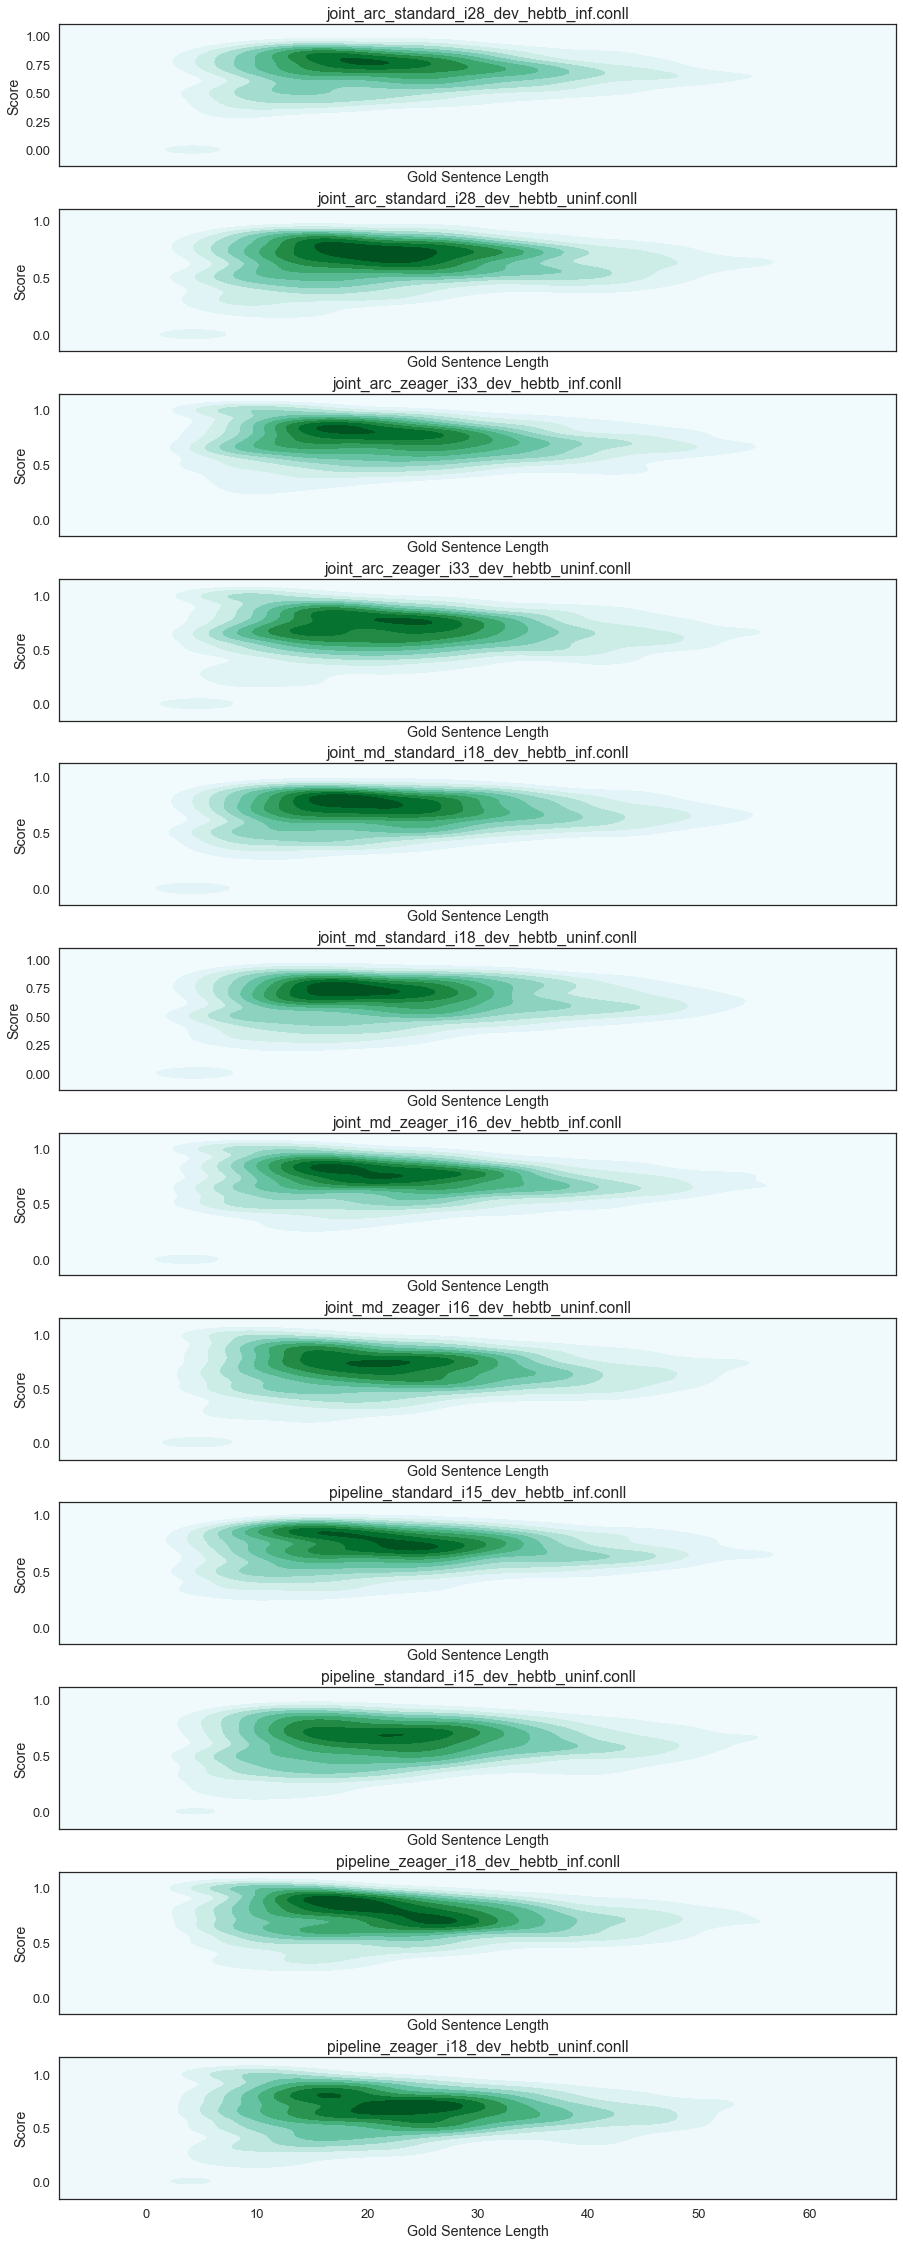

In [98]:
f, axes = plt.subplots(len(test_paths), 1, figsize=(15,40), sharex=True)
for i, ax in enumerate(f.axes):
    sns.kdeplot(test_gold_len[test_gold_len<60], test_nop_scores[i][test_gold_len<60], shade=True, ax=ax)
    ax.set_xlabel('Gold Sentence Length')
    ax.set_ylabel('Score')
    ax.set_title(os.path.basename(dev_paths[i]))
f.subplots_adjust(hspace=0.3)

### Length-difference vs. Score
#### With Punctuation
##### DEV

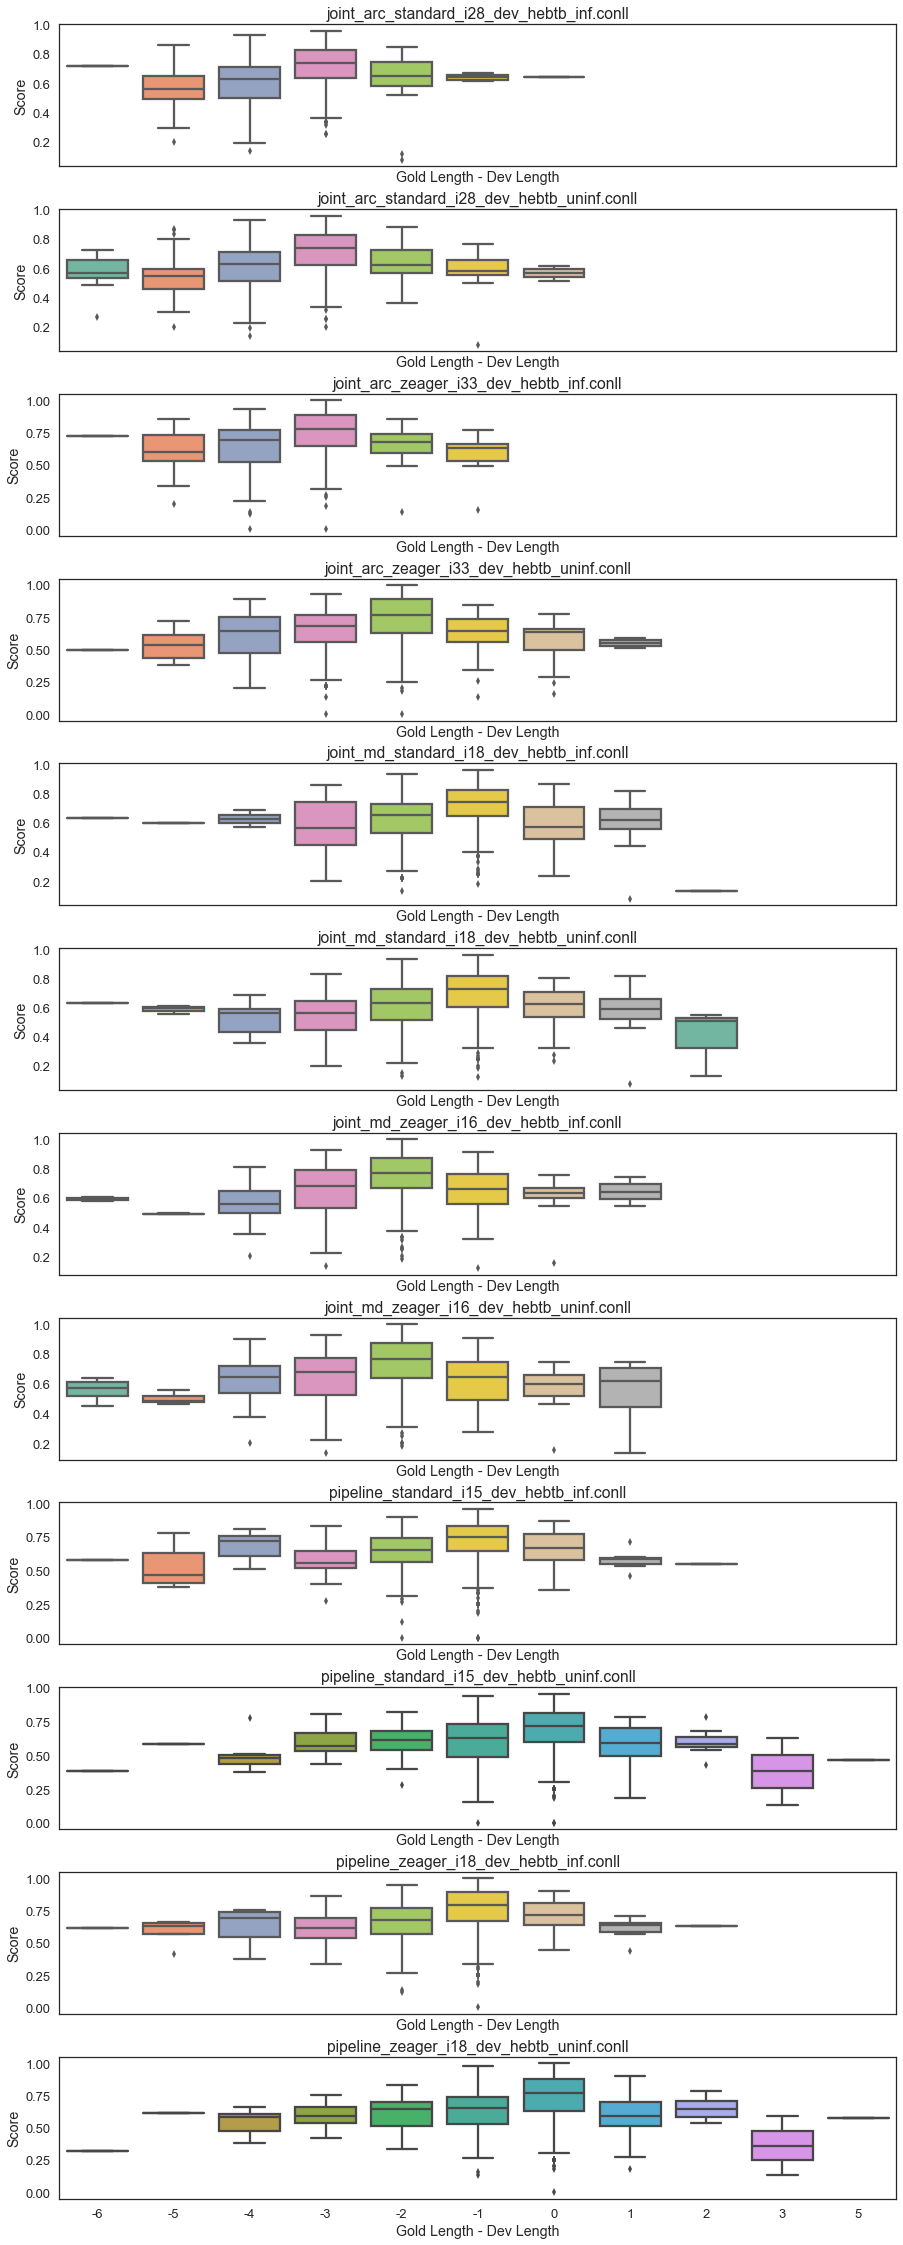

In [99]:
f, axes = plt.subplots(len(dev_paths), 1, figsize=(15,40), sharex=True)
for i, ax in enumerate(f.axes):
    sns.boxplot(x=dev_gold_len - dev_dfs[i].groupby('sent').size(), y=dev_scores[i], ax=ax)
    ax.set_xlabel('Gold Length - Dev Length')
    ax.set_ylabel('Score')
    ax.set_title(os.path.basename(dev_paths[i]))
f.subplots_adjust(hspace=0.3)

##### TEST

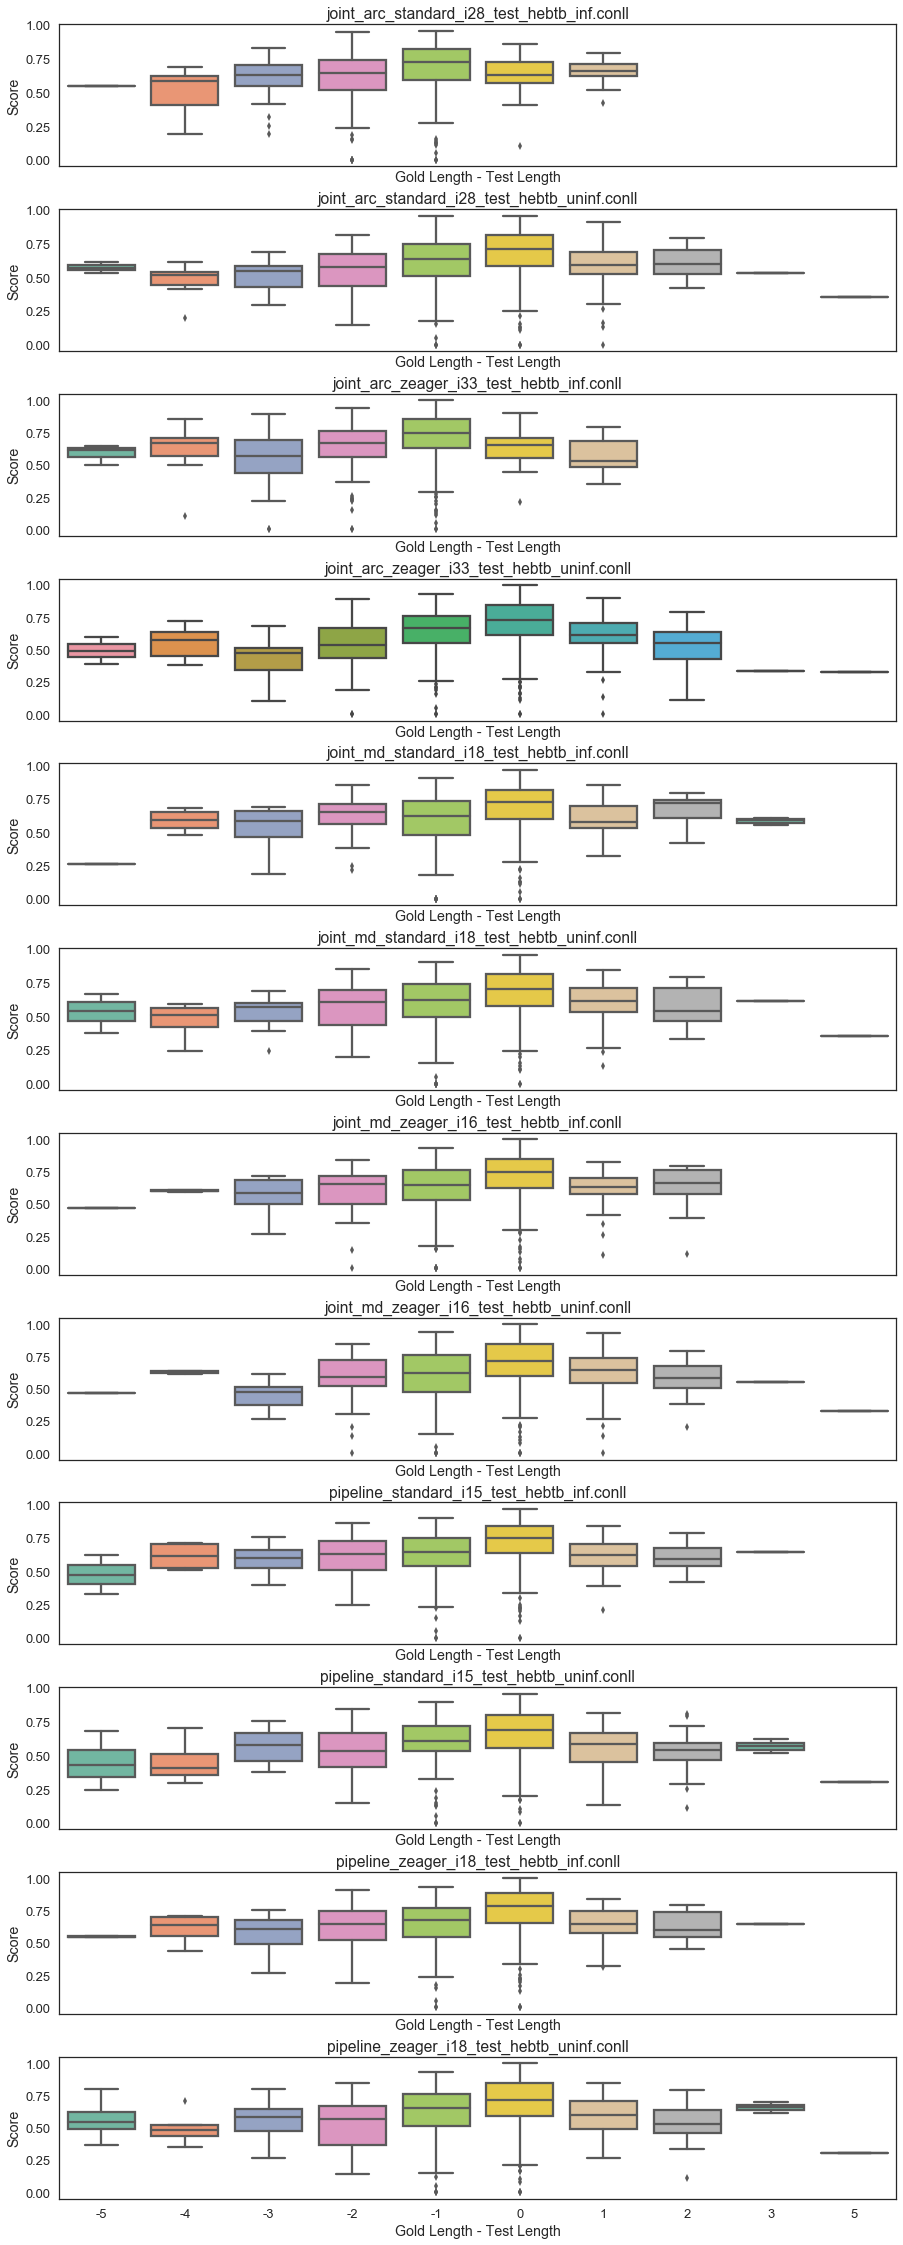

In [100]:
f, axes = plt.subplots(len(test_paths), 1, figsize=(15,40), sharex=True)
for i, ax in enumerate(f.axes):
    sns.boxplot(x=test_gold_len - test_dfs[i].groupby('sent').size(), y=test_scores[i], ax=ax)
    ax.set_xlabel('Gold Length - Test Length')
    ax.set_ylabel('Score')
    ax.set_title(os.path.basename(test_paths[i]))
f.subplots_adjust(hspace=0.3)

#### Without Punctuation
##### DEV

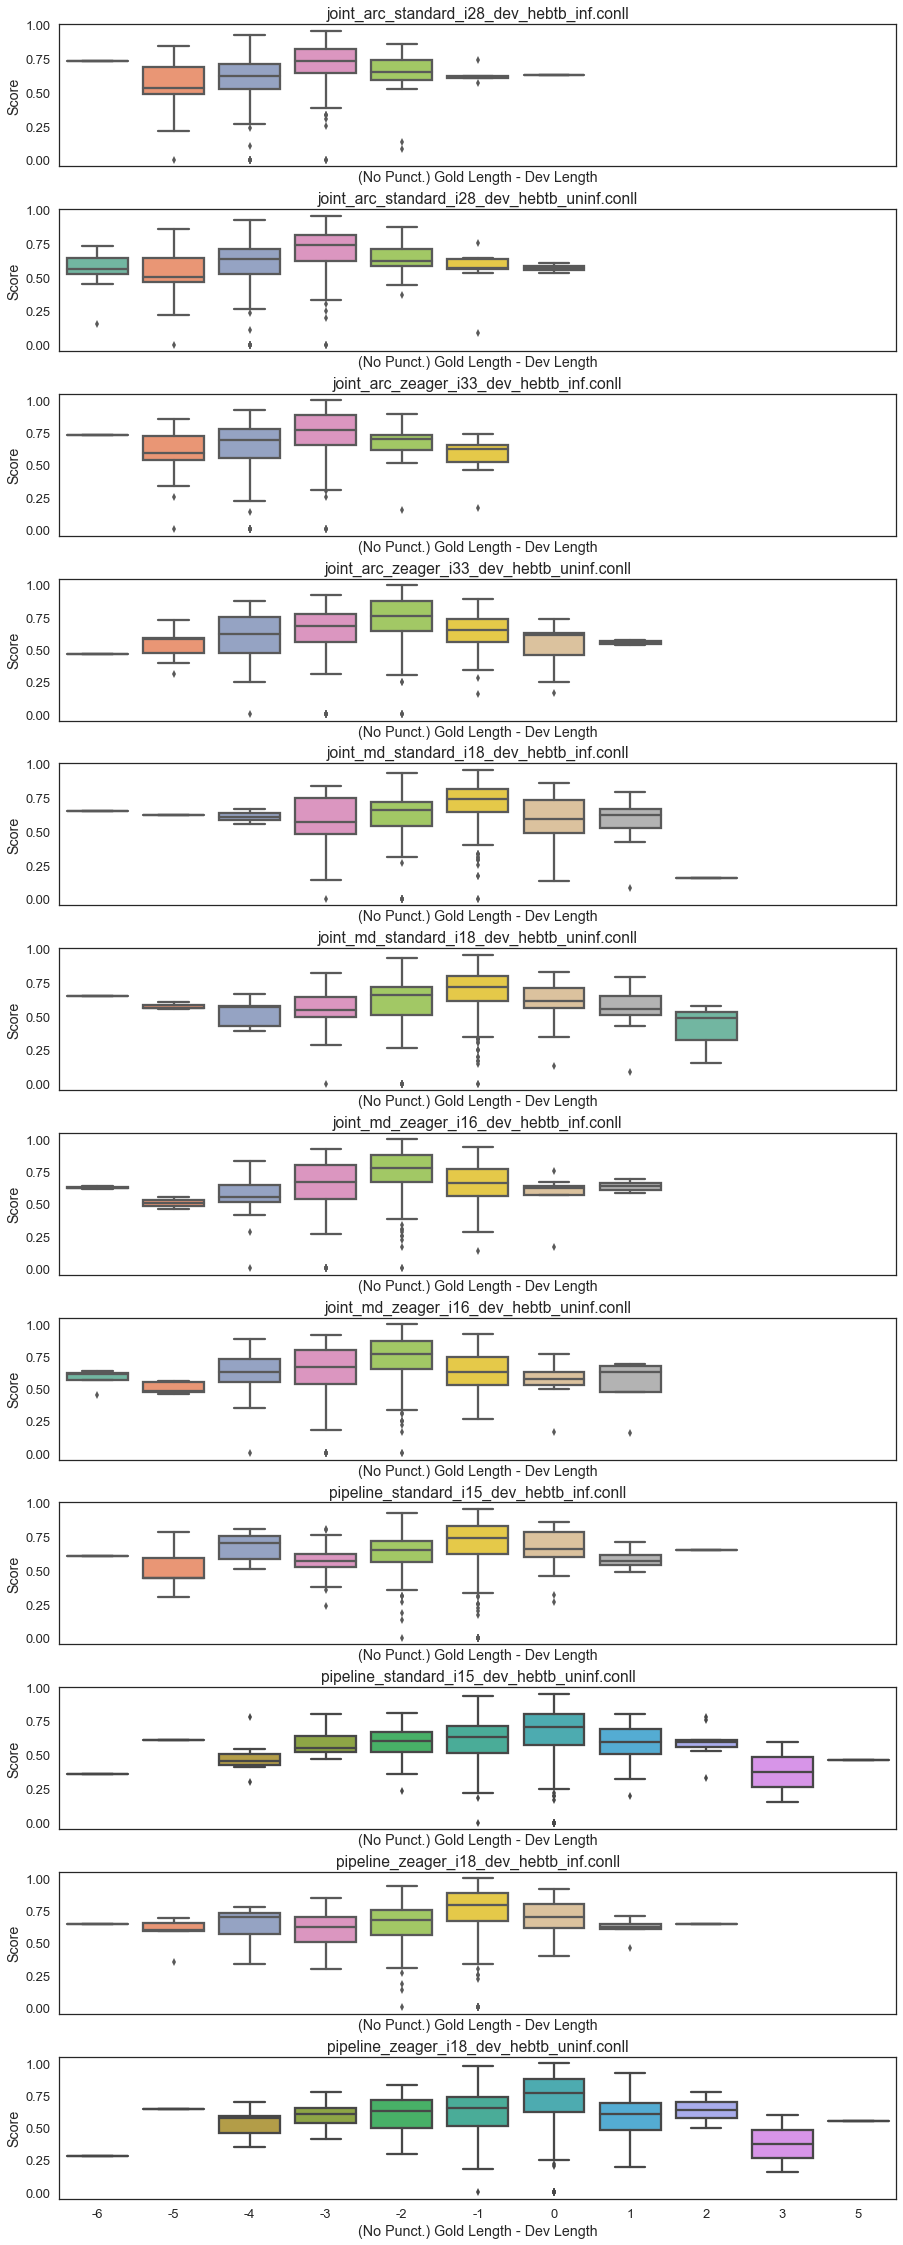

In [105]:
dev_gold_nop_len = dev_gold_nop.groupby('sent').size()
f, axes = plt.subplots(len(dev_paths), 1, figsize=(15,40), sharex=True)
for i, ax in enumerate(f.axes):
    sns.boxplot(x=dev_gold_nop_len - dev_nop[i].groupby('sent').size(), y=dev_nop_scores[i], ax=ax)
    ax.set_xlabel('(No Punct.) Gold Length - Dev Length')
    ax.set_ylabel('Score')
    ax.set_title(os.path.basename(dev_paths[i]))
f.subplots_adjust(hspace=0.3)

##### TEST

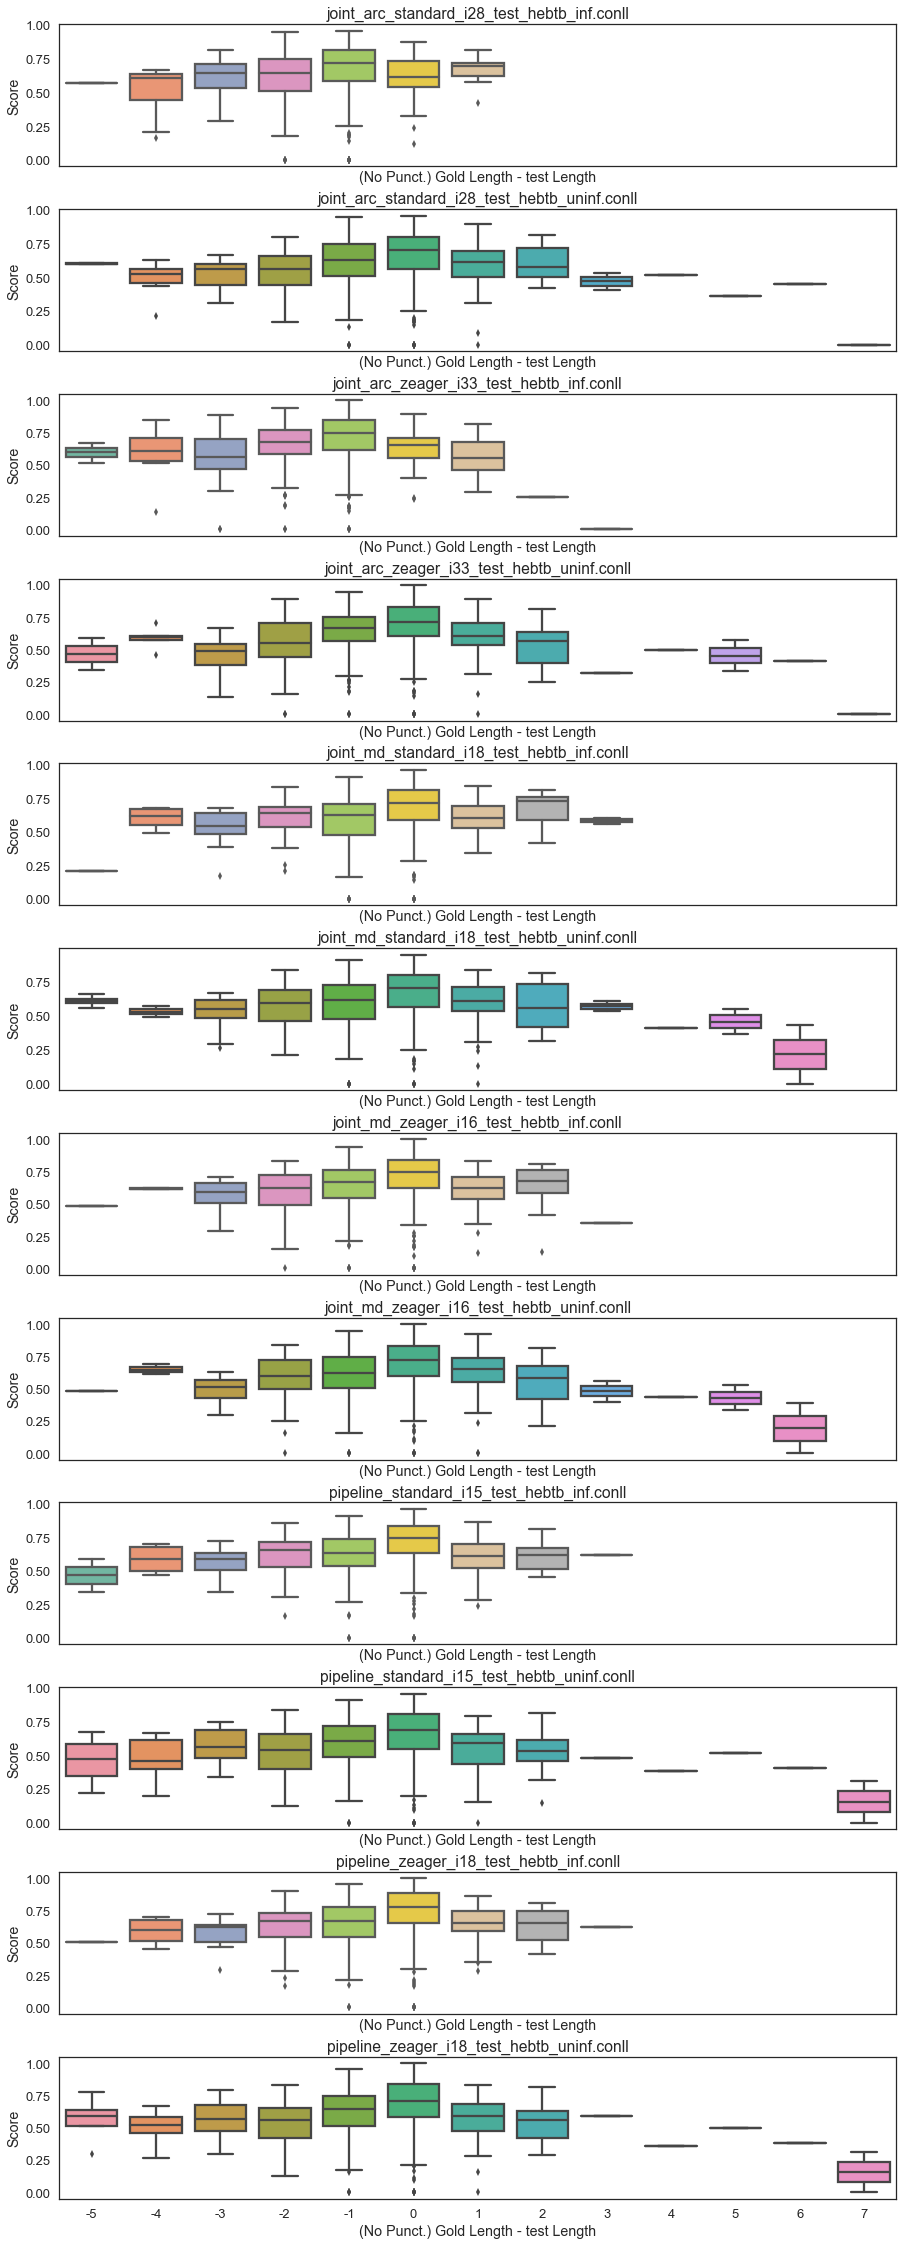

In [106]:
test_gold_nop_len = test_gold_nop.groupby('sent').size()
f, axes = plt.subplots(len(test_paths), 1, figsize=(15,40), sharex=True)
for i, ax in enumerate(f.axes):
    sns.boxplot(x=test_gold_nop_len - test_nop[i].groupby('sent').size(), y=test_nop_scores[i], ax=ax)
    ax.set_xlabel('(No Punct.) Gold Length - test Length')
    ax.set_ylabel('Score')
    ax.set_title(os.path.basename(test_paths[i]))
f.subplots_adjust(hspace=0.3)